## Bayesian rolling regression for pairs trading

In my article – [‘Statistical Arbitrage with Pairs Trading and Backtesting’](https://www.linkedin.com/pulse/statistical-arbitrage-pairs-trading-backtesting-sabir-jana/), we discussed about pairs trading as a popular trading strategy that relies on the cointegration of two assets. Given a pair of assets, we need to estimate the hedging ratio to decide on the relative magnitude of long and short positions and we used linear regression for this purpose. A frequentist approach provides us point estimate however a Bayesian inference can help us to understand changes to parameters over the period. The approach and code of this notebook is based on the rolling regression example provide by Thomas Wiecki's.

In [9]:
# necessary imports of libraries 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pathlib import Path

import numpy as np
import theano
import pymc3 as pm
import arviz as az

from sklearn.preprocessing import scale

import yfinance as yf

import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

We identified multiple cointegrated pair of assets in [‘Statistical Arbitrage with Pairs Trading and Backtesting'](https://www.linkedin.com/pulse/statistical-arbitrage-pairs-trading-backtesting-sabir-jana/) article and used the pair of Bank of Baroda and Stat Bank of India as a trading pair. Let’s use the same pair and calculate hedge ratio over time.

In [30]:
start = '2010-01-01'
end = '2020-12-11'

In [31]:
# download the data from yahoo finance
prices = yf.download('BANKBARODA.BO SBIN.BO', start=start, end=end).dropna().loc[:, 'Adj Close']

[*********************100%***********************]  2 of 2 completed


In [32]:
prices.columns = ['BANKBARODA','SBIN']
prices.head()

,BANKBARODA,SBIN
Date,,
2010-01-04,51.141144,95.124893
2010-01-05,52.710426,95.137367
2010-01-06,53.053093,95.683197
2010-01-07,53.246765,95.166412
2010-01-08,53.514942,94.933945


In [33]:
# get the daily returns
returns = prices.pct_change().dropna()
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2696 entries, 2010-01-05 to 2020-12-10
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BANKBARODA  2696 non-null   float64
 1   SBIN        2696 non-null   float64
dtypes: float64(2)
memory usage: 63.2 KB


Variables measured on very different scales can slow down the sampling process. Hence, we first apply the scale() function provided by scikit-learn to standardize all features

In [34]:
prices_normed = prices.apply(scale)
prices_normed.head()

,BANKBARODA,SBIN
Date,,
2010-01-04,-1.722028,-1.535756
2010-01-05,-1.682472,-1.535587
2010-01-06,-1.673835,-1.528208
2010-01-07,-1.668954,-1.535194
2010-01-08,-1.662194,-1.538337


Plotting the prices over time suggests a strong correlation. However, the correlation seems to change over time.

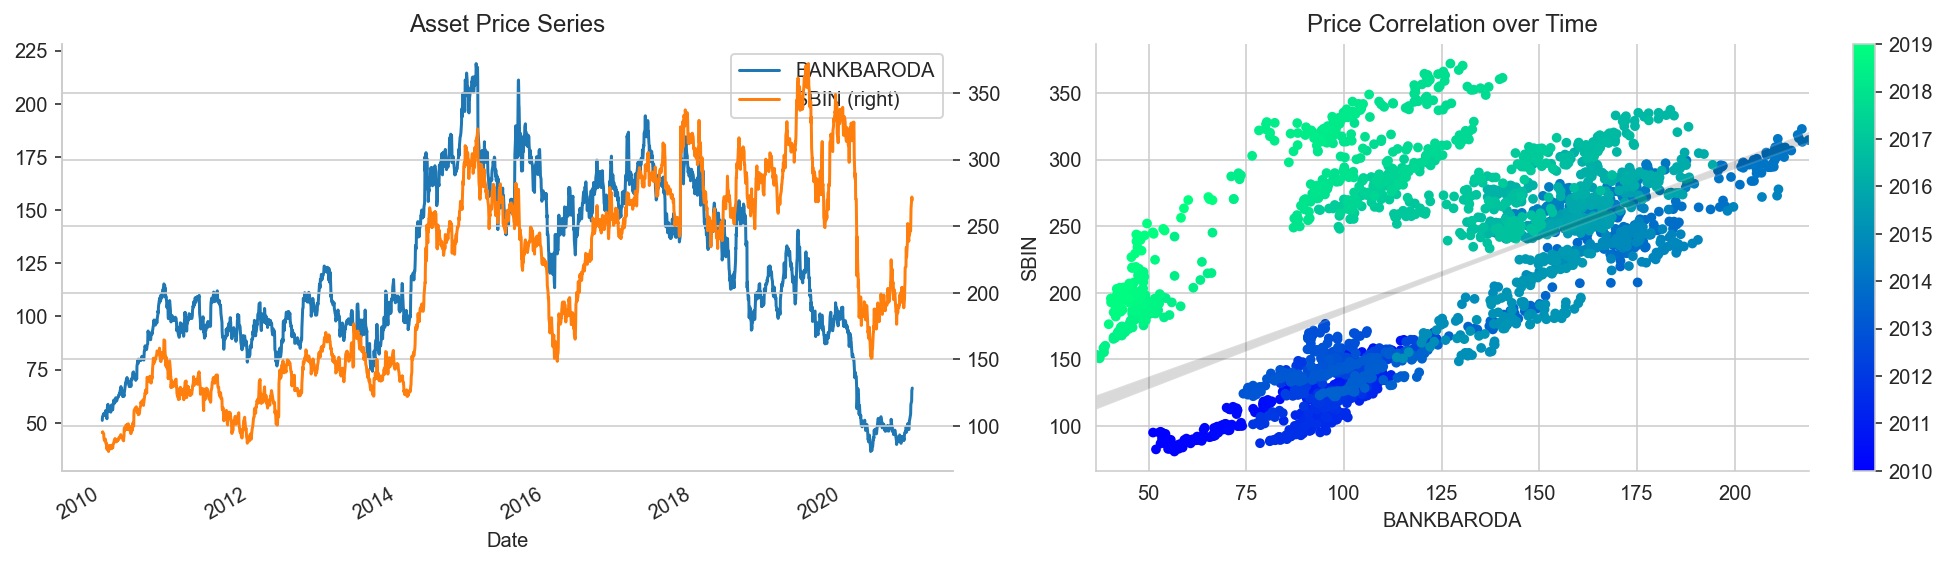

In [35]:
fig, axes= plt.subplots(figsize=(14,4), ncols=2)

prices.plot(secondary_y='SBIN', ax=axes[0])
axes[0].set_title('Asset Price Series')
points = axes[1].scatter(prices.BANKBARODA,
                         prices.SBIN,
                         c=np.linspace(0.1, 1, len(prices)), 
                         s=15, 
                         cmap='winter')
axes[1].set_title('Price Correlation over Time')
cbar = plt.colorbar(points, ax=axes[1])
cbar.ax.set_yticklabels([str(p.year) for p in returns[::len(returns)//10].index]);

sns.regplot(x='BANKBARODA', y='SBIN', 
            data=prices, 
            scatter=False, 
            color='k',
            line_kws={'lw':1, 
                      'ls':'--'},
            ax=axes[1])
sns.despine()
fig.tight_layout();
plt.savefig('images/image1',dpi=300)

A naive approach would be to estimate a linear model and ignore the time domain.

In [36]:
with pm.Model() as model_reg:
    pm.glm.GLM.from_formula('SBIN ~ BANKBARODA', prices)
    trace_reg = pm.sample(draws=5000,
                          tune=1000,
                          cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, BANKBARODA, Intercept]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 6000/6000 [01:04<00:00, 92.79it/s]
The acceptance probability does not match the target. It is 0.9836677508724959, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9827629656389009, but should be close to 0.8. Try to increase the number of tuning steps.


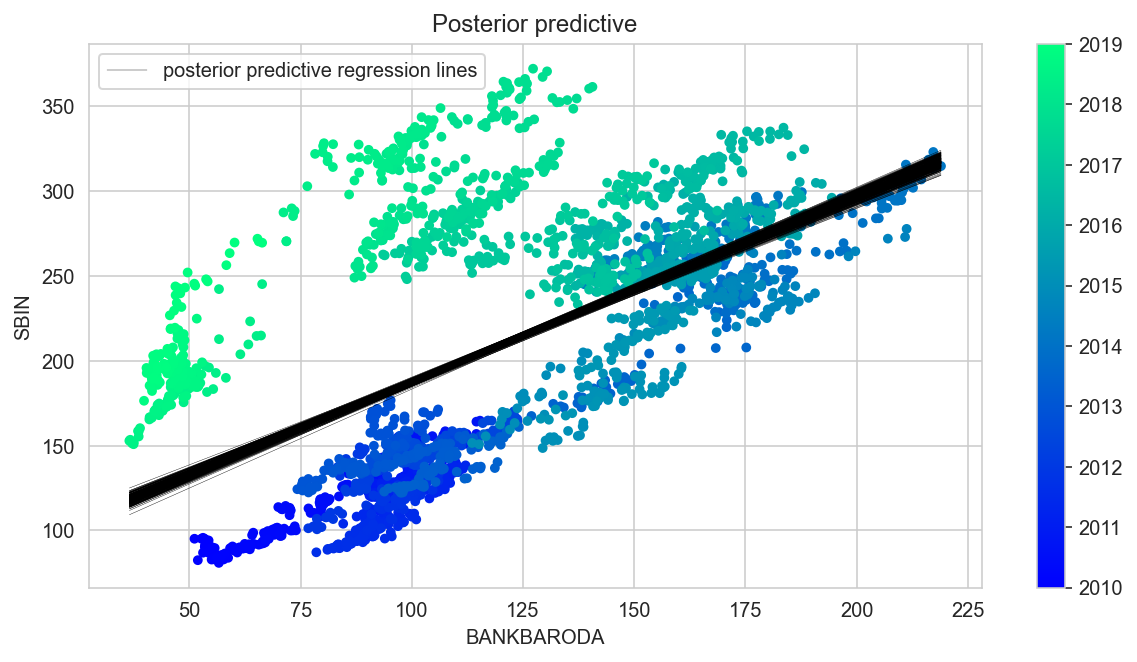

In [37]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, 
                     xlabel='BANKBARODA', 
                     ylabel='SBIN',
                     title='Posterior predictive regression lines')
points = ax.scatter(prices.BANKBARODA,
                         prices.SBIN,
                         c=np.linspace(0.1, 1, len(prices)), 
                         s=15, 
                         cmap='winter')

pm.plot_posterior_predictive_glm(trace_reg[100:], 
                                 samples=250, 
                                 label='posterior predictive regression lines',
                                 lm=lambda x, 
                                 sample: sample['Intercept'] + sample['BANKBARODA'] * x,
                                 eval=np.linspace(prices.BANKBARODA.min(), prices.BANKBARODA.max(), 100))
cb = plt.colorbar(points)
cb.ax.set_yticklabels([str(p.year) for p in prices[::len(prices)//10].index]);
ax.legend(loc=0);

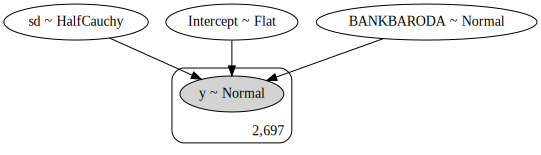

In [38]:
# model diagram
pm.model_to_graphviz(model=model_reg)

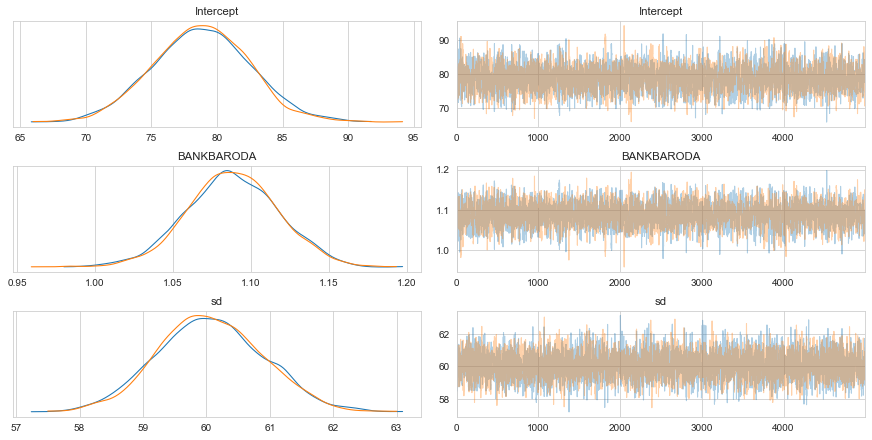

In [29]:
az.plot_trace(trace_reg,); # var_names=['α', 'β', 'ε'])

## Rolling regression

Next, we will build an improved model that will allow for changes in the regression coefficients over time. Specifically, we will assume that intercept and slope follow a random-walk through time.

$$\begin{align*} 
\alpha_t &\sim \mathcal{N}(\alpha_{t-1}, \sigma_\alpha^2)\\
\beta_t & \sim \mathcal{N}(\beta_{t-1}, \sigma_\beta^2)
\end{align*}$$

First, lets define the hyper-priors for $\sigma_\alpha^2$ and $\sigma_\beta^2$. This parameter can be interpreted as the volatility in the regression coefficients.

In [41]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 50.)    
    alpha = pm.GaussianRandomWalk('alpha', 
                                  sd=sigma_alpha, 
                                  shape=len(prices))
    
    sigma_beta = pm.Exponential('sigma_beta', 50.) 
    beta = pm.GaussianRandomWalk('beta', 
                                 sd=sigma_beta, 
                                 shape=len(prices))

Perform the regression given coefficients and data and link to the data via the likelihood.

In [42]:
with model_randomwalk:
    # Define regression
    regression = alpha + beta * prices_normed.BANKBARODA
    
    # Assume prices are normally distributed
    # Get mean from regression.
    sd = pm.HalfNormal('sd', sd=.1)
    likelihood = pm.Normal('y', 
                           mu=regression, 
                           sd=sd, 
                           observed=prices_normed.SBIN)

Inference. Despite this being quite a complex model, NUTS handles it wells.

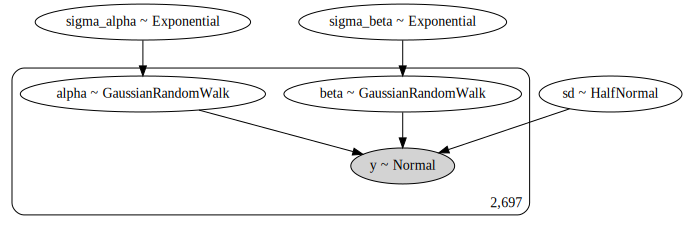

In [43]:
pm.model_to_graphviz(model_randomwalk)

In [44]:
with model_randomwalk:
    trace_rw = pm.sample(tune=2000, 
                         draws=200,
                         cores=1,
                         target_accept=.9)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, beta, sigma_beta, alpha, sigma_alpha]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 2200/2200 [14:56<00:00,  2.46it/s]
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


Increasing the tree-depth does indeed help but it makes sampling very slow. The results look identical with this run, however

## Analysis of results

As can be seen below, $\alpha$, the intercept, changes over time.

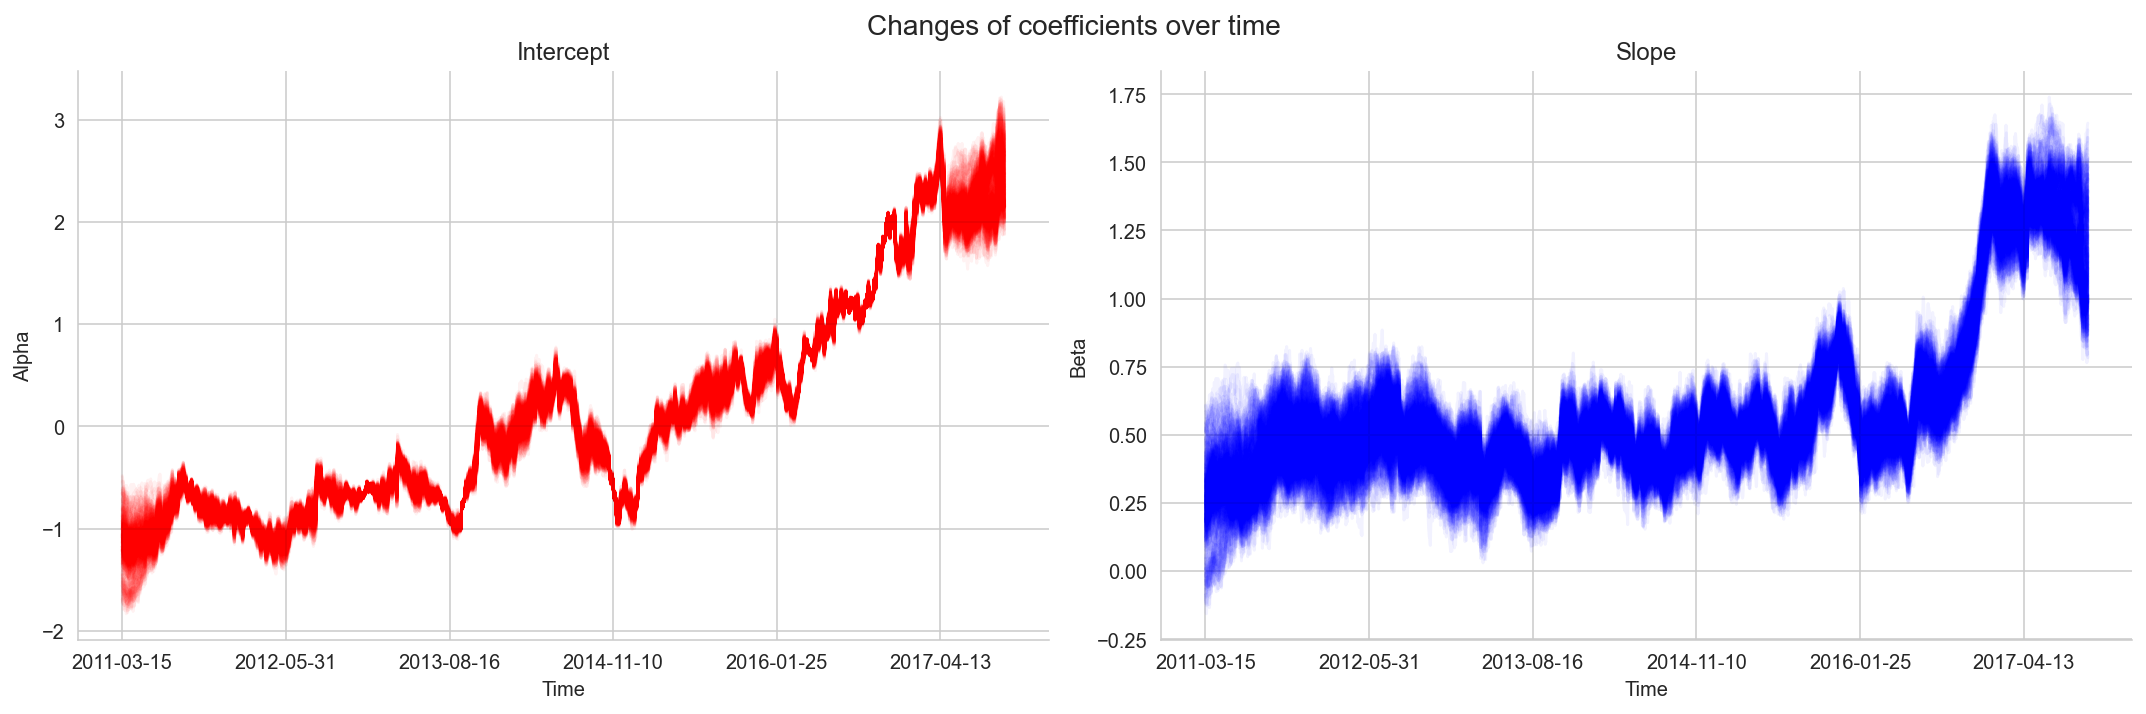

In [45]:
fig, axes = plt.subplots(figsize=(15, 5), ncols=2, sharex=True)

axes[0].plot(trace_rw['alpha'].T, 'r', alpha=.05)
axes[0].set_xlabel('Time') 
axes[0].set_ylabel('Alpha')
axes[0].set_title('Intercept')
axes[0].set_xticklabels([str(p.date()) for p in prices[::len(prices)//9].index])

axes[1].plot(trace_rw['beta'].T, 'b', alpha=.05)
axes[1].set_xlabel('Time') 
axes[1].set_ylabel('Beta')
axes[1].set_title('Slope')

fig.suptitle('Changes of coefficients over time', fontsize=14)
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.9);
plt.savefig('images/image4', dpi=300)

The posterior predictive plot shows that we capture the change in regression over time much better. Note that we should have used returns instead of prices. The model would still work the same, but the visualisations would not be quite as clear.

In [46]:
# az.plot_pair(trace_rw, var_names=['alpha', 'beta'], plot_kwargs={'alpha': 0.1})

In [47]:
x = np.linspace(prices_normed.BANKBARODA.min(), 
                 prices_normed.BANKBARODA.max())

dates = [str(p.year) for p in prices[::len(prices)//9].index]

colors = np.linspace(0.1, 1, len(prices))
colors_sc = np.linspace(0.1, 1, len(trace_rw[::10]['alpha'].T))

cmap = plt.get_cmap('winter')

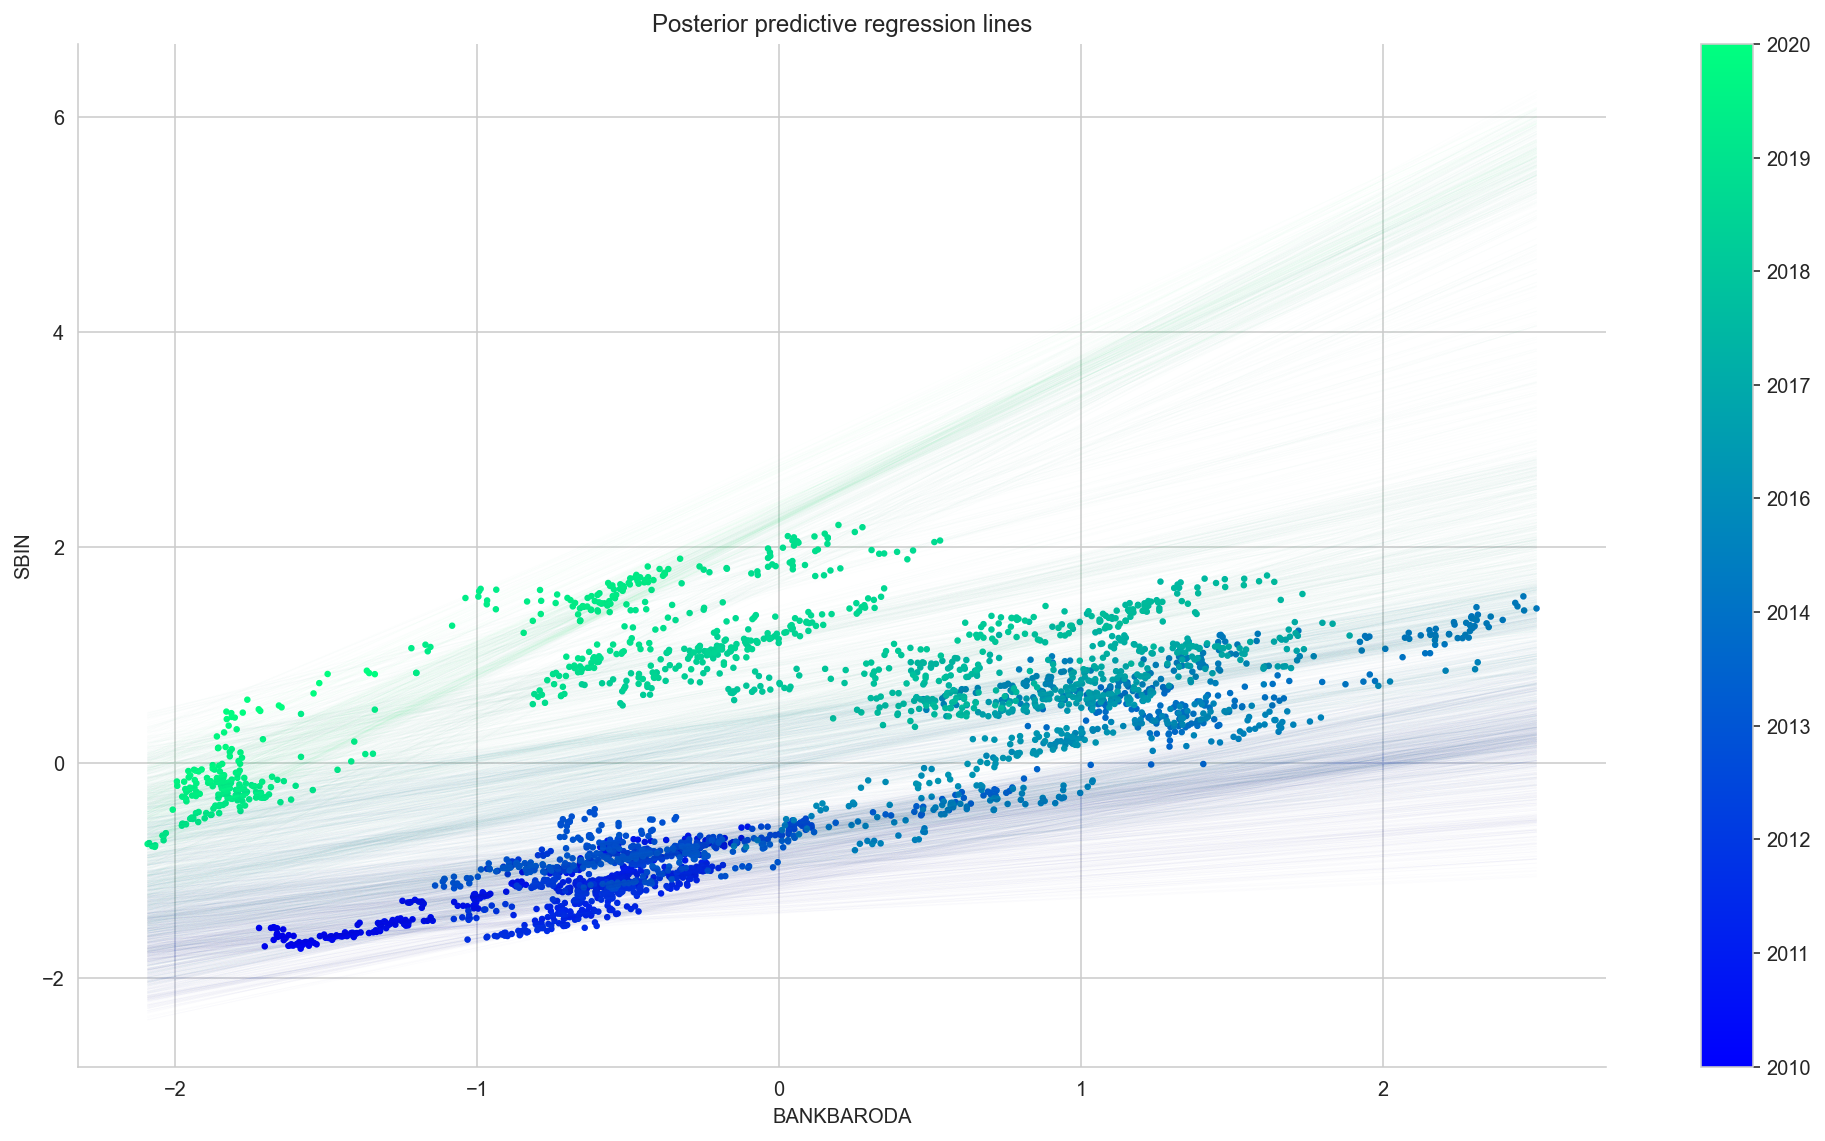

In [49]:
fig, ax = plt.subplots(figsize=(14, 8))

for i, (alpha, beta) in enumerate(zip(trace_rw[::25]['alpha'].T, 
                                      trace_rw[::25]['beta'].T)):
    for a, b in zip(alpha[::25], beta[::25]):
        ax.plot(x,
                a + b*x,
                alpha=.01,
                lw=.5,
                c=cmap(colors_sc[i]))
        
points = ax.scatter(prices_normed.BANKBARODA,
                    prices_normed.SBIN,
                    c=colors,
                    s=5, 
                    cmap=cmap)

cbar = plt.colorbar(points)
cbar.ax.set_yticklabels(dates);

ax.set_xlabel('BANKBARODA')
ax.set_ylabel('SBIN')
ax.set_title('Posterior predictive regression lines')
sns.despine()
fig.tight_layout();
plt.savefig('images/image5', dpi=300)

In [45]:
# az.plot_trace(trace_rw, var_names=['alpha', 'beta']);